# Master's Thesis: Investigating Maximum Rainfall Trends in Colorado

<b>Institution:</b> University of Georgia <br>
<b>Department:</b> Statistics <br>
<b>Student:</b> Jeremy Mulcahey <br>
<b>Advisor:</b> Dr. Lynne Seymour <br>
<b>Last Edit:</b> 9/27/2016

Section 0: Preparing data <br>
Section 1: Parameter Estimation<br>
Section 2: Probabilities of Interest

##  Section 0: Preparing data

In [1]:
require(fitdistrplus); # required for parameter estimation
require(caTools);      # required for smoothing
require(repr);         # required for resizing plots in IRKernel
require("IRdisplay");  # graphic embedding
require(MASS);         # testing

Loading required package: fitdistrplus
Loading required package: MASS
Loading required package: survival
Loading required package: caTools
Loading required package: repr
Loading required package: IRdisplay


In [2]:
# establish working directorys
setwd("C:/Users/jerem/Desktop/UGA/Master'sThesis/")

Data files for individual station names.

In [4]:
data = read.csv(file = "data/GREELEY_MonMax_GHCN.csv", head=T)

Adjust the data for later use.

In [5]:
# Create an index as x - used as needed
month = seq(1,nrow(data),by=1)
data = cbind(data,month)

# first year of the data (changes by station name)
firstYear = data$YEAR[1]

# station name for plotting
stationName = as.character(data$STATION_NAME[1])

# -999 messed with the plotting - change to NA
data[data==-999] = NA

sum(is.na(data)) #print number of missing values

[1] 51

Check number of years in the data set.

In [6]:
data$YEAR[nrow(data)]-firstYear

[1] 121

In [7]:
table(data$MONTH)


  1   2   3   4   5   6   7   8   9  10  11  12 
113 114 117 115 115 115 117 115 115 117 116 116 

In [8]:
fillInMonths = c(8,4,4,9,seq(1,12,1),1,12,9,seq(1,12,1),seq(1,12,1),seq(1,12,1),seq(1,12,1),2,5,1,6,1,2,11,6,1,2,5,8)

In [9]:
fillInYears = c(1897,1898,1905,1906,rep(1907,12),1908,1912,1913,rep(1914,12),rep(1915,12),rep(1916,12),rep(1917,12),
                1918,1919,1920,1920,1922,1923,1927,1928,1948,1948,1955,1957)

In [10]:
for(i in 1:length(fillInMonths)){
    data=rbind(data,c("GHCND:USC00053546", "GREELEY CO US",fillInYears[i],fillInMonths[i],31,-999))
}

In [11]:
data=data[order(data$YEAR,as.integer(data$MONTH)),]

In [12]:
data$Max.PRCP.=as.integer(data$Max.PRCP.)

In [13]:
data[data==-999] = NA

Make a data frame of all the 10 year periods following the first year for data collected at the station.

In [37]:
#create the first decade (first year and the following 9 years)
max_PRCP = data.frame(data[which(data$YEAR < (firstYear + 10)),6])

# add all the subsequent decades to the data frame incrementing by 1 year at a time
for(year in c((firstYear+ 1):2005)){
    max_PRCP = cbind(max_PRCP,data[which(data$YEAR >= year & data$YEAR < year+10),6])
}

# name the columns as the first year of the observed 10 year periods
colnames(max_PRCP) = as.character(c(firstYear:2005))

# set the missing values to NA
max_PRCP[max_PRCP==-999] = NA

## Section 1: Parameter Estimation

In [38]:
options(repr.plot.width=9, repr.plot.height=8) #reduces the plot sizes

In [39]:
mleGamma = data.frame(alpha = double(),
                 theta = double(),
                 KS = double(),
                 KStest = character(),
                 CvM = double(),
                 CvMtest = character(),
                 AD = double(),
                 ADtest = character(),
                 stringsAsFactors = FALSE)
                
for (i in 1:length(max_PRCP)) {

    testDist = na.omit(max_PRCP[,i])
        
        for(j in 1:length(testDist)){
            if(testDist[j] < .1){
            testDist[j]=.0001
            }
        }

   gamma1 = fitdist(as.vector(testDist),"gamma",method = "mle")
   mleGamma[i,1] = gamma1$estimate[1]
   mleGamma[i,2] = gamma1$estimate[2]
   
   gof = gofstat(gamma1)
   mleGamma[i,3] = gof$ks
   mleGamma[i,4] = gof$kstest
   mleGamma[i,5] = gof$cvm
   mleGamma[i,6] = gof$cvmtest
   mleGamma[i,7] = gof$ad
   mleGamma[i,8] = gof$adtest
}

mleGamma["invTheta"] = 1/(mleGamma$theta)
mleGamma["mean"] = mleGamma$invTheta*mleGamma$alpha
mleGamma["var"] = mleGamma$alpha*(mleGamma$invTheta^2)
mleGamma["sd"] = sqrt(mleGamma$var)

In [40]:
mleExp = data.frame(theta = double(),
                 KS = double(),
                 KStest = character(),
                 CvM = double(),
                 CvMtest = character(),
                 AD = double(),
                 ADtest = character(),
                 stringsAsFactors = FALSE)
                
for (i in 1:length(max_PRCP)) {

    testDist = na.omit(max_PRCP[,i])
        
        for(j in 1:length(testDist)){
            if(testDist[j] < .1){
            testDist[j]=.0001
            }
        }

   exp1 = fitdist(as.vector(testDist),"exp",method = "mle")
   mleExp[i,1] = exp1$estimate[1]
   
   gof = gofstat(exp1)
   mleExp[i,2] = gof$ks
   mleExp[i,3] = gof$kstest
   mleExp[i,4] = gof$cvm
   mleExp[i,5] = gof$cvmtest
   mleExp[i,6] = gof$ad
   mleExp[i,7] = gof$adtest
}

mleExp["mean"] = 1/mleExp$theta
mleExp["square"] = mleExp$theta^2 
mleExp["var"] = 1/mleExp$square
mleExp["sd"] = sqrt(mleExp$var)

In [41]:
mleWB = data.frame(alpha = double(),theta = double(),
                 KS = double(),
                 KStest = character(),
                 CvM = double(),
                 CvMtest = character(),
                 AD = double(),
                 ADtest = character(),
                 stringsAsFactors = FALSE)
                
for (i in 1:length(max_PRCP)) {

    testDist = na.omit(max_PRCP[,i])
        
        for(j in 1:length(testDist)){
            if(testDist[j] < .1){
            testDist[j]=.0001
            }
        }

   WB1 = fitdist(as.vector(testDist),"weibull",method = "mle")
   mleWB[i,1] = WB1$estimate[1]
   mleWB[i,2] = WB1$estimate[2]
   
   gof = gofstat(WB1)
   mleWB[i,3] = gof$ks
   mleWB[i,4] = gof$kstest
   mleWB[i,5] = gof$cvm
   mleWB[i,6] = gof$cvmtest
   mleWB[i,7] = gof$ad
   mleWB[i,8] = gof$adtest
}


#mleWB["mean"] = 1/mleWB$theta
#mleWB["square"] = mleWB$theta^2 
#mleWB["var"] = 1/mleWB$square
#mleWB["sd"] = sqrt(mleWB$var)

In [42]:
which(mleWB$KStest=="rejected")

[1]  1  2  3  4  5  6  7  8  9 10 11 12 31 32 33 34 35 36 37 38 39 40 41 42 57
[26] 61

In [43]:
table(mleWB$KStest)
table(mleExp$KStest)
table(mleGamma$KStest)


not rejected     rejected 
          87           26 


not rejected     rejected 
         112            1 


not rejected     rejected 
          63           50 

In [44]:
which(mleGamma$KStest=="rejected")

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  27  28  30  31  32  33
[20]  34  35  36  37  38  39  40  41  42  43  48  53  54  55  56  57  58  59  60
[39]  61  62  63  64  65  73  95  96  97  98  99 113

In [45]:
which(mleExp$KStest=="rejected")

[1] 98

In [46]:
head(mleGamma)

alpha,theta,KS,KStest,CvM,CvMtest,AD,ADtest,invTheta,mean,var,sd
0.6474406,0.005679314,0.1521824,rejected,0.7895008,NA,5.044678,NA,176.0776,113.9998,20072.81,141.6785
0.6530769,0.005623333,0.1630926,rejected,0.8874197,NA,5.433698,NA,177.8305,116.1370,20652.70,143.7105
0.6005093,0.004915726,0.1870250,rejected,1.1501432,NA,6.857243,NA,203.4288,122.1609,24851.03,157.6421
0.5881354,0.005017828,0.1871342,rejected,1.1042300,NA,6.549344,NA,199.2894,117.2092,23358.54,152.8350
0.5286206,0.004331709,0.2024560,rejected,1.2163282,NA,7.161606,NA,230.8558,122.0351,28172.52,167.8467
0.4932175,0.004124360,0.2103536,rejected,1.1408949,NA,6.700025,NA,242.4619,119.5865,28995.16,170.2796


In [47]:
head(mleExp)

theta,KS,KStest,CvM,CvMtest,AD,ADtest,mean,square,var,sd
0.008773886,0.06090150,not rejected,0.07973956,not rejected,2.414923,rejected,113.9746,7.698108e-05,12990.20,113.9746
0.008609368,0.07579102,not rejected,0.12467181,not rejected,2.630620,rejected,116.1525,7.412121e-05,13491.41,116.1525
0.008185349,0.07913885,not rejected,0.13130519,not rejected,3.605546,rejected,122.1695,6.699994e-05,14925.39,122.1695
0.008531427,0.07106623,not rejected,0.11643453,not rejected,3.543398,rejected,117.2137,7.278525e-05,13739.05,117.2137
0.008193247,0.06417898,not rejected,0.07447672,not rejected,4.588688,rejected,122.0517,6.712930e-05,14896.62,122.0517
0.008358541,0.06666583,not rejected,0.05545958,not rejected,4.987563,rejected,119.6381,6.986521e-05,14313.28,119.6381


In [48]:
trueEst = NULL
for(i in 1:nrow(mleExp)){
    if(mleExp$KStest[i] == "not rejected" & mleGamma$KStest[i] == "not rejected"){
        trueEst = c(trueEst,"plot")
    }
    if(mleExp$KStest[i] == "not rejected" & mleGamma$KStest[i] == "rejected"){
        trueEst = c(trueEst,"exp")
    }
    if(mleExp$KStest[i] == "rejected" & mleGamma$KStest[i] == "not rejected"){
        trueEst = c(trueEst,"gamma")
    }
    if(mleExp$KStest[i] == "rejected" & mleGamma$KStest[i] == "rejected"){
        trueEst = c(trueEst,"fail")
    }
}

In [49]:
table(trueEst)
print(table(mleWB$KStest))

trueEst
 exp fail plot 
  49    1   63 


not rejected     rejected 
          87           26 


In [50]:
mleGamma[which(mleWB$KStest=="rejected"),"KStest"] == "not rejected"

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE

In [51]:
mleExp[which(mleWB$KStest=="rejected"),"KStest"] == "not rejected"

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [52]:
which(mleWB$KStest=="rejected")

[1]  1  2  3  4  5  6  7  8  9 10 11 12 31 32 33 34 35 36 37 38 39 40 41 42 57
[26] 61

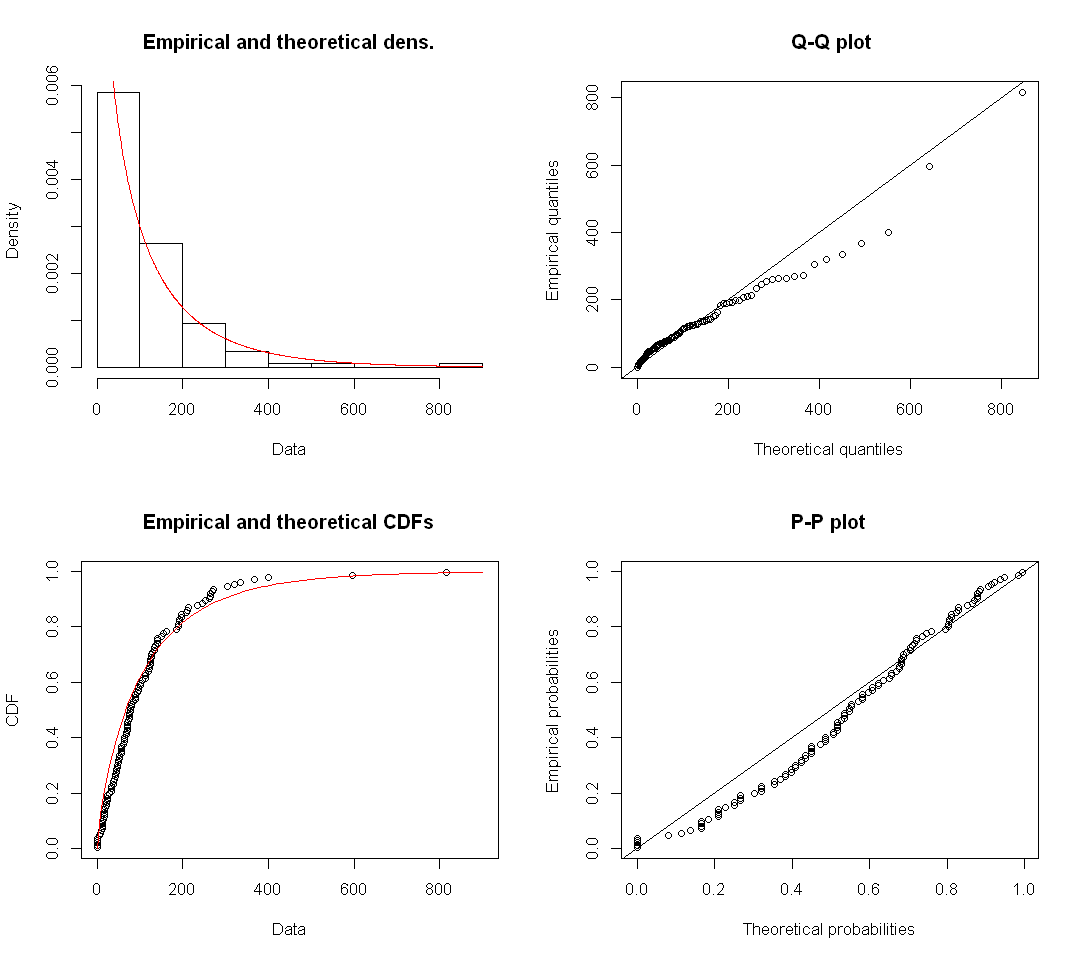

In [53]:
testDist = na.omit(max_PRCP[,1])

    for(j in 1:length(testDist)){
        if(testDist[j] < .1){
        testDist[j]=.0001
        }
    }

plot(fitdist(as.vector(testDist),"weibull",method = "mle"))

In [54]:
mleGamma[1,"KStest"];mleExp[1,"KStest"];mleWB[1,"KStest"]

[1] "rejected"

[1] "not rejected"

[1] "rejected"

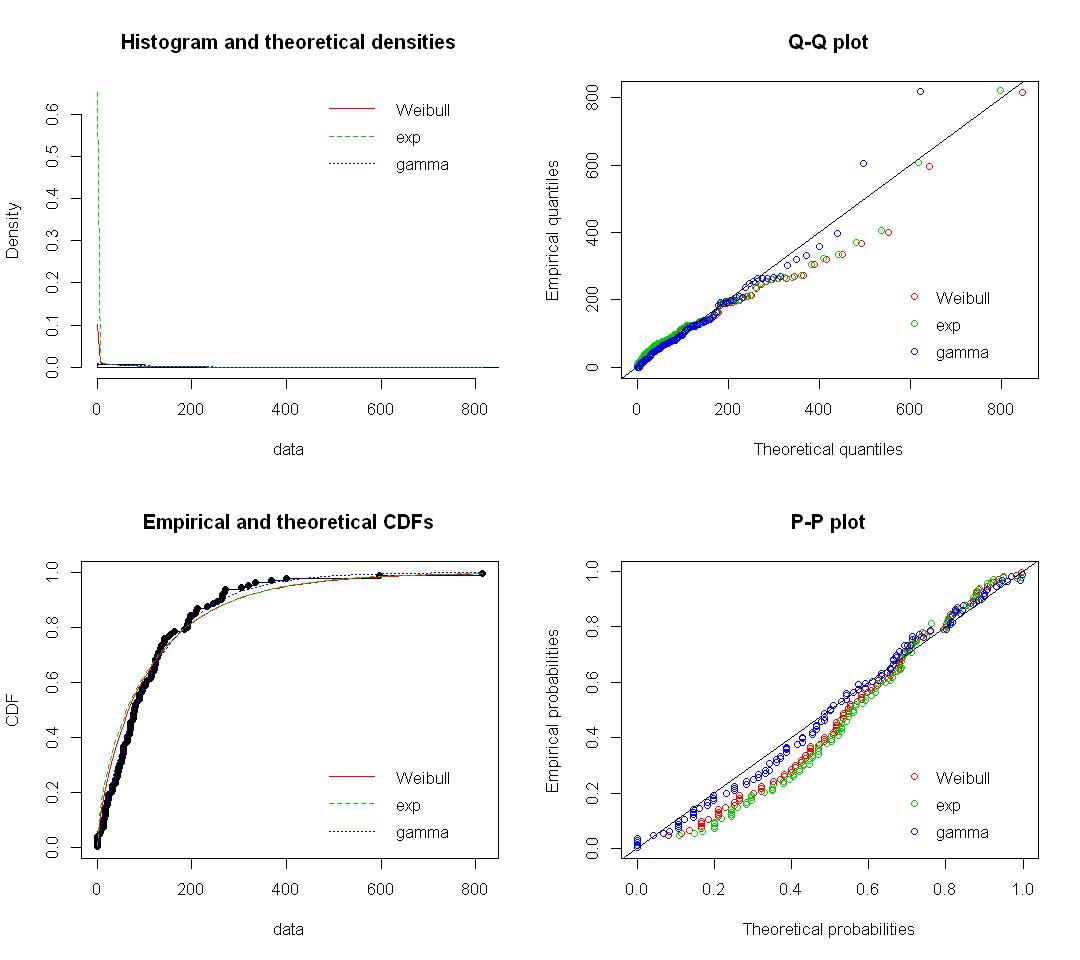

In [55]:
testDist = na.omit(max_PRCP[,1])

    for(j in 1:length(testDist)){
        if(testDist[j] < .1){
        testDist[j]=.0001
        }
    }

fw = fitdist(as.vector(testDist), "weibull", method="mle")
fg = fitdist(as.vector(testDist), "exp", method="mle")
fln = fitdist(as.vector(testDist), "gamma", method="mle")
par(mfrow = c(2, 2))
plot.legend <- c("Weibull", "exp", "gamma")
denscomp(list(fw, fln, fg), legendtext = plot.legend)
qqcomp(list(fw, fln, fg), legendtext = plot.legend)
cdfcomp(list(fw, fln, fg), legendtext = plot.legend)
ppcomp(list(fw, fln, fg), legendtext = plot.legend)

In [56]:
mleGamma[2,"KStest"];mleExp[2,"KStest"];mleWB[2,"KStest"]

[1] "rejected"

[1] "not rejected"

[1] "rejected"

In [57]:
mleGamma[3,"KStest"];mleExp[3,"KStest"];mleWB[3,"KStest"]

[1] "rejected"

[1] "not rejected"

[1] "rejected"

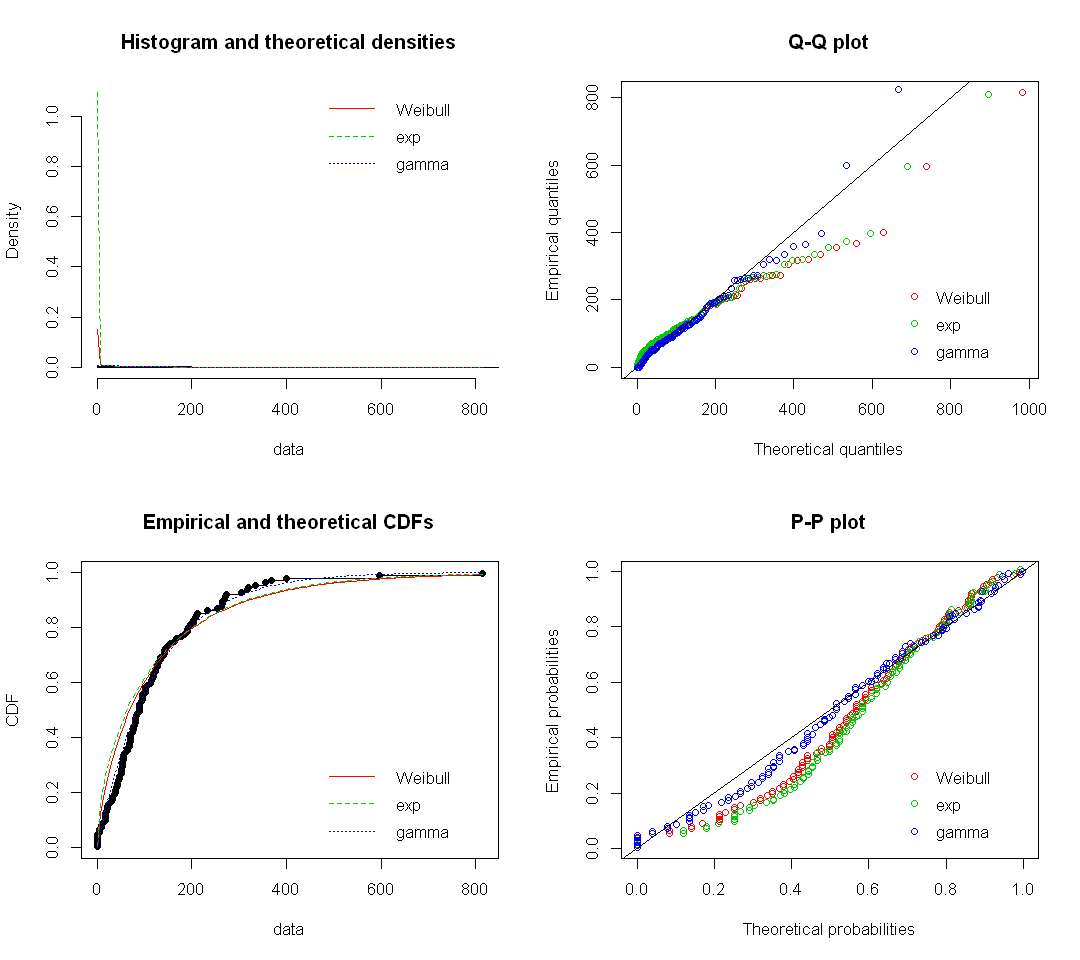

In [58]:
testDist = na.omit(max_PRCP[,3])

    for(j in 1:length(testDist)){
        if(testDist[j] < .1){
        testDist[j]=.0001
        }
    }

fw = fitdist(as.vector(testDist), "weibull", method="mle")
fg = fitdist(as.vector(testDist), "exp", method="mle")
fln = fitdist(as.vector(testDist), "gamma", method="mle")
par(mfrow = c(2, 2))
plot.legend <- c("Weibull", "exp", "gamma")
denscomp(list(fw, fln, fg), legendtext = plot.legend)
qqcomp(list(fw, fln, fg), legendtext = plot.legend)
cdfcomp(list(fw, fln, fg), legendtext = plot.legend)
ppcomp(list(fw, fln, fg), legendtext = plot.legend)

In [59]:
mleGamma[45,"KStest"];mleExp[45,"KStest"];mleWB[45,"KStest"]

[1] "not rejected"

[1] "not rejected"

[1] "not rejected"

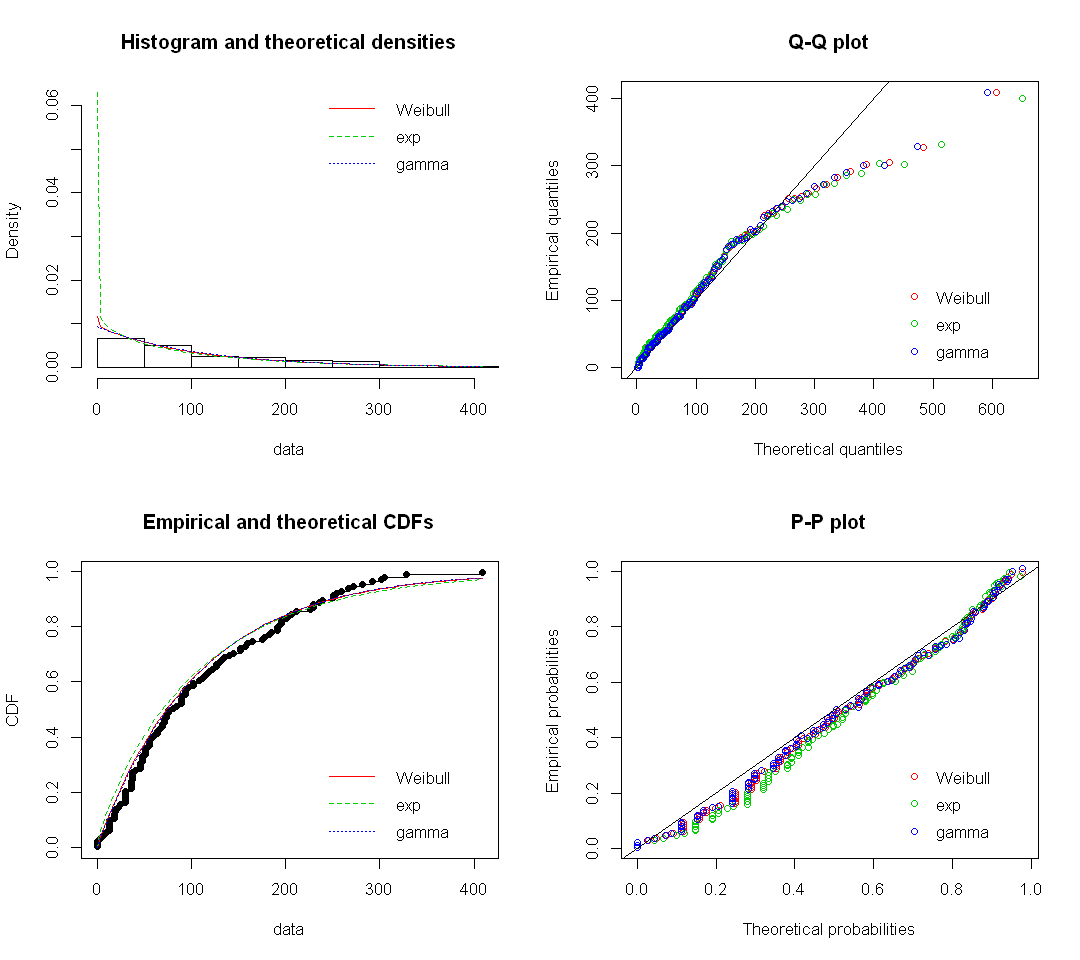

In [60]:
testDist = na.omit(max_PRCP[,45])

    for(j in 1:length(testDist)){
        if(testDist[j] < .1){
        testDist[j]=.0001
        }
    }

fw = fitdist(as.vector(testDist), "weibull", method="mle")
fg = fitdist(as.vector(testDist), "exp", method="mle")
fln = fitdist(as.vector(testDist), "gamma", method="mle")
par(mfrow = c(2, 2))
plot.legend <- c("Weibull", "exp", "gamma")
denscomp(list(fw, fln, fg), legendtext = plot.legend)
qqcomp(list(fw, fln, fg), legendtext = plot.legend)
cdfcomp(list(fw, fln, fg), legendtext = plot.legend)
ppcomp(list(fw, fln, fg), legendtext = plot.legend)

Tried failed fits with normal distribution

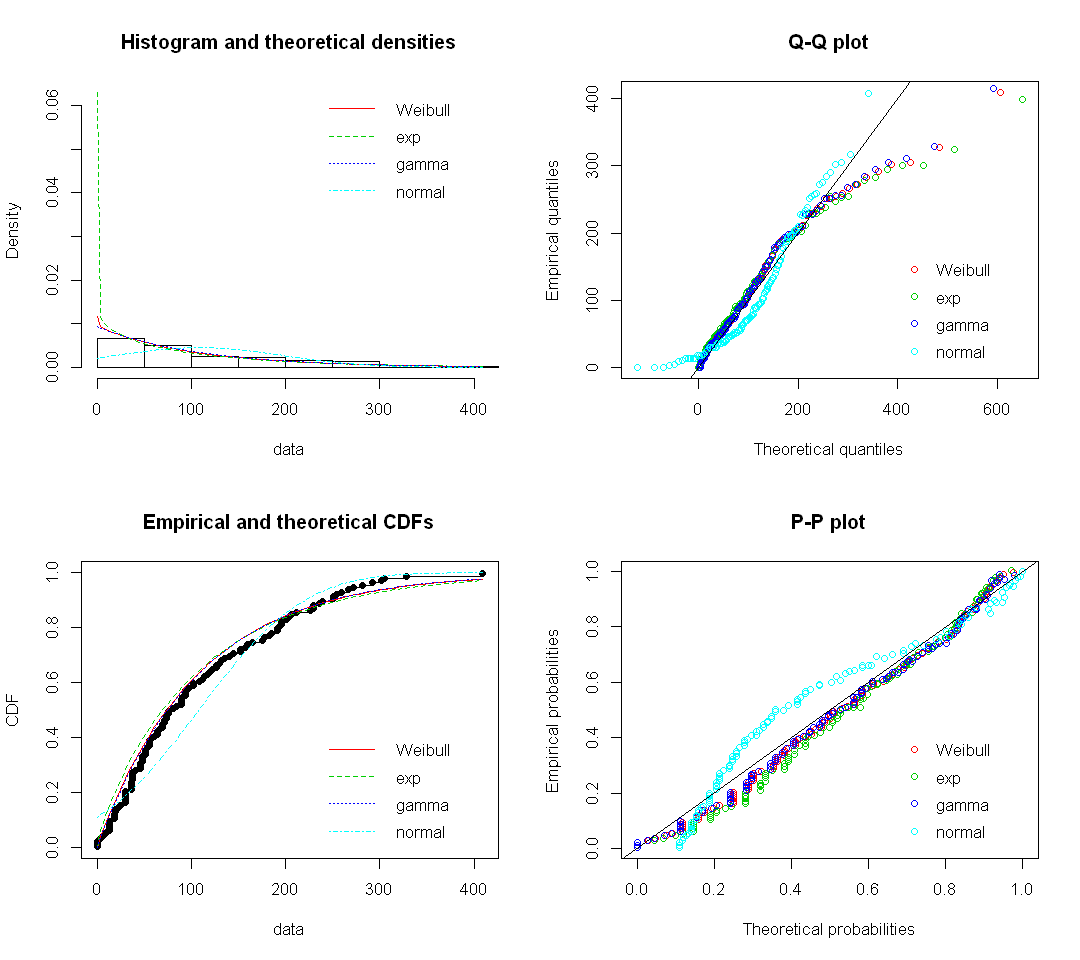

In [61]:
testDist = na.omit(max_PRCP[,45])

    for(j in 1:length(testDist)){
        if(testDist[j] < .1){
        testDist[j]=.0001
        }
    }

fw = fitdist(as.vector(testDist), "weibull", method="mle")
fg = fitdist(as.vector(testDist), "exp", method="mle")
fln = fitdist(as.vector(testDist), "gamma", method="mle")
norm = fitdist(as.vector(testDist), "norm", method="mle")

par(mfrow = c(2, 2))
plot.legend <- c("Weibull", "exp", "gamma","normal")
denscomp(list(fw, fln, fg,norm), legendtext = plot.legend)
qqcomp(list(fw, fln, fg,norm), legendtext = plot.legend)
cdfcomp(list(fw, fln, fg,norm), legendtext = plot.legend)
ppcomp(list(fw, fln, fg,norm), legendtext = plot.legend)

Try good fits with normal distribution

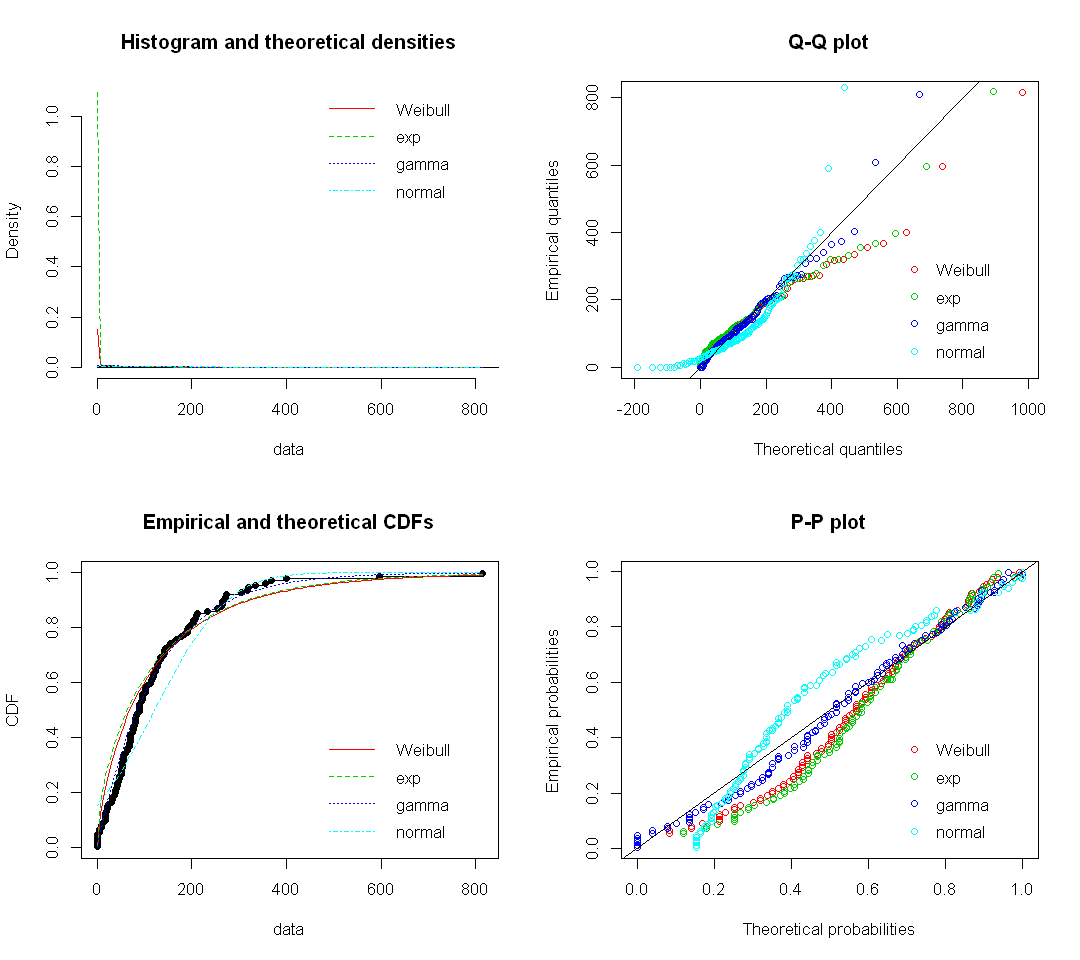

In [62]:
testDist = na.omit(max_PRCP[,3])

    for(j in 1:length(testDist)){
        if(testDist[j] < .1){
        testDist[j]=.0001
        }
    }

fw = fitdist(as.vector(testDist), "weibull", method="mle")
fg = fitdist(as.vector(testDist), "exp", method="mle")
fln = fitdist(as.vector(testDist), "gamma", method="mle")
norm = fitdist(as.vector(testDist), "norm", method="mle")

par(mfrow = c(2, 2))
plot.legend <- c("Weibull", "exp", "gamma","normal")
denscomp(list(fw, fln, fg,norm), legendtext = plot.legend)
qqcomp(list(fw, fln, fg,norm), legendtext = plot.legend)
cdfcomp(list(fw, fln, fg,norm), legendtext = plot.legend)
ppcomp(list(fw, fln, fg,norm), legendtext = plot.legend)

In [63]:
which(trueEst=="fail")

[1] 98

In [64]:
which(trueEst=="plot")

[1]  14  15  16  17  18  19  20  21  22  23  24  25  26  29  44  45  46  47  49
[20]  50  51  52  66  67  68  69  70  71  72  74  75  76  77  78  79  80  81  82
[39]  83  84  85  86  87  88  89  90  91  92  93  94 100 101 102 103 104 105 106
[58] 107 108 109 110 111 112

In [65]:
mleWB2 = data.frame(alpha = double(),theta = double(),
                 KS = double(),
                 KStest = character(),
                 CvM = double(),
                 CvMtest = character(),
                 AD = double(),
                 ADtest = character(),
                 stringsAsFactors = FALSE)
                
for (i in 1:length(max_PRCP)) {
    
    testDist = na.omit(max_PRCP[,i])
        
        for(j in 1:length(testDist)){
            if(testDist[j] < .1){
            testDist[j]=.0001
            }
        }
    
   WB1 = fitdist(as.vector(testDist),"weibull",method = "mge", gof="ADR")
   mleWB2[i,1] = WB1$estimate[1]
   mleWB2[i,2] = WB1$estimate[2]
   
   gof = gofstat(WB1)
   mleWB2[i,3] = gof$ks
   mleWB2[i,4] = gof$kstest
   mleWB2[i,5] = gof$cvm
   mleWB2[i,6] = gof$cvmtest
   mleWB2[i,7] = gof$ad
   mleWB2[i,8] = gof$adtest
}


#mleWB["mean"] = 1/mleWB$theta
#mleWB["square"] = mleWB$theta^2 
#mleWB["var"] = 1/mleWB$square
#mleWB["sd"] = sqrt(mleWB$var)

In [66]:
table(mleWB2[,4])
table(mleWB[,4])


not rejected 
         113 


not rejected     rejected 
          87           26 

In [67]:
mleGamma2 = data.frame(alpha = double(),
                 theta = double(),
                 KS = double(),
                 KStest = character(),
                 CvM = double(),
                 CvMtest = character(),
                 AD = double(),
                 ADtest = character(),
                 stringsAsFactors = FALSE)
                
for (i in 1:length(max_PRCP)) {

    testDist = na.omit(max_PRCP[,i])
        
        for(j in 1:length(testDist)){
            if(testDist[j] < .1){
            testDist[j]=.0001
            }
        }

   gamma1 = fitdist(as.vector(testDist),"gamma",method = "mge", gof="ADR")
   mleGamma2[i,1] = gamma1$estimate[1]
   mleGamma2[i,2] = gamma1$estimate[2]
   
   gof = gofstat(gamma1)
   mleGamma2[i,3] = gof$ks
   mleGamma2[i,4] = gof$kstest
   mleGamma2[i,5] = gof$cvm
   mleGamma2[i,6] = gof$cvmtest
   mleGamma2[i,7] = gof$ad
   mleGamma2[i,8] = gof$adtest
}

mleGamma["invTheta"] = 1/(mleGamma$theta)
mleGamma["mean"] = mleGamma$invTheta*mleGamma$alpha
mleGamma["var"] = mleGamma$alpha*(mleGamma$invTheta^2)
mleGamma["sd"] = sqrt(mleGamma$var)

In [68]:
table(mleGamma2[,4])


not rejected 
         113 

In [69]:
table(mleGamma[,4])


not rejected     rejected 
          63           50 

In [70]:
mleExp2 = data.frame(theta = double(),
                 KS = double(),
                 KStest = character(),
                 CvM = double(),
                 CvMtest = character(),
                 AD = double(),
                 ADtest = character(),
                 stringsAsFactors = FALSE)
                
for (i in 1:length(max_PRCP)) {

    testDist = na.omit(max_PRCP[,i])
        
        for(j in 1:length(testDist)){
            if(testDist[j] < .1){
            testDist[j]=.0001
            }
        }

   exp1 = fitdist(as.vector(testDist),"exp",method = "mge",gof="ADR")
   mleExp2[i,1] = exp1$estimate[1]
   
   gof = gofstat(exp1)
   mleExp2[i,2] = gof$ks
   mleExp2[i,3] = gof$kstest
   mleExp2[i,4] = gof$cvm
   mleExp2[i,5] = gof$cvmtest
   mleExp2[i,6] = gof$ad
   mleExp2[i,7] = gof$adtest
}

mleExp2["mean"] = 1/mleExp2$theta
mleExp2["square"] = mleExp2$theta^2 
mleExp2["var"] = 1/mleExp2$square
mleExp2["sd"] = sqrt(mleExp2$var)

In [71]:
table(mleExp2[,3])
table(mleExp[,3])


not rejected 
         113 


not rejected     rejected 
         112            1 

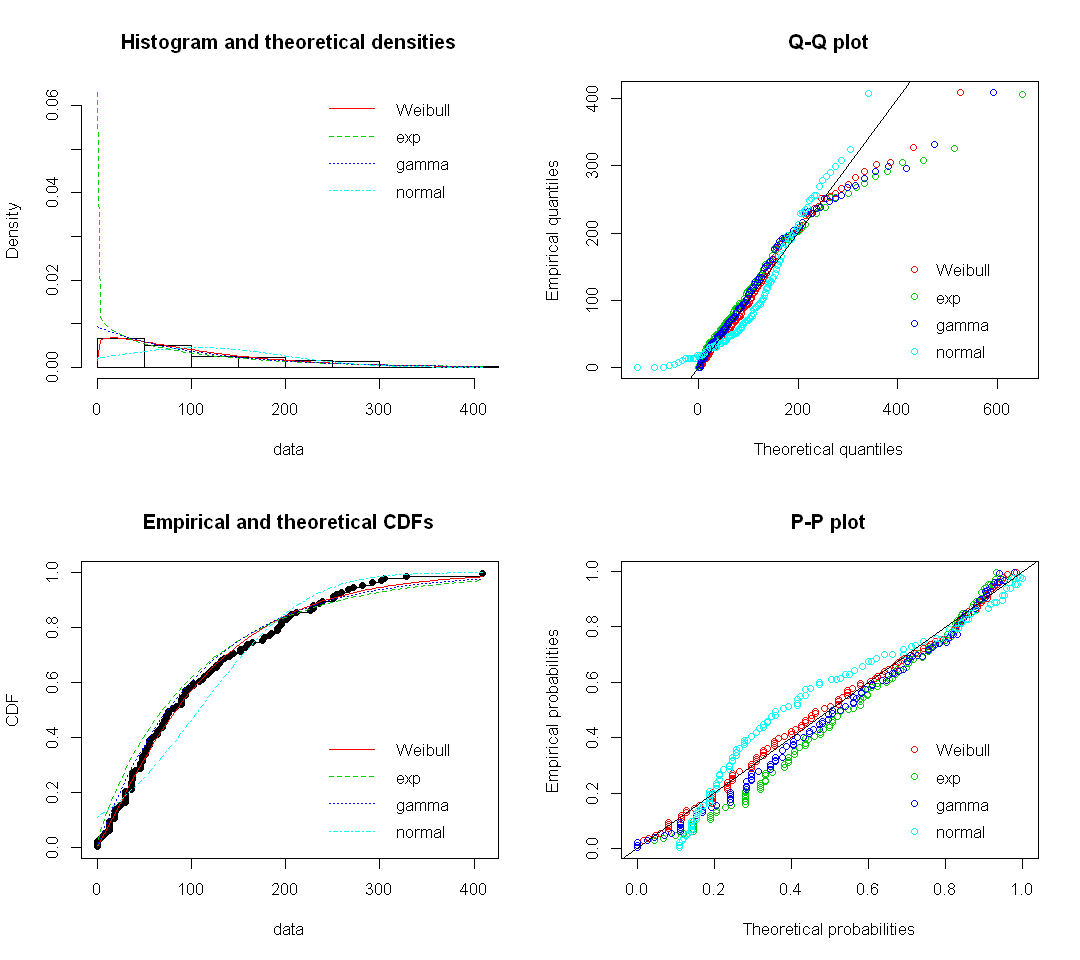

In [72]:
testDist = na.omit(max_PRCP[,45])

    for(j in 1:length(testDist)){
        if(testDist[j] < .1){
        testDist[j]=.0001
        }
    }

fw = fitdist(as.vector(testDist), "weibull", method="mge",gof="ADR")
fg = fitdist(as.vector(testDist), "exp", method="mle")
fln = fitdist(as.vector(testDist), "gamma", method="mle")
norm = fitdist(as.vector(testDist), "norm", method="mle")

par(mfrow = c(2, 2))
plot.legend <- c("Weibull", "exp", "gamma","normal")
denscomp(list(fw, fln, fg,norm), legendtext = plot.legend)
qqcomp(list(fw, fln, fg,norm), legendtext = plot.legend)
cdfcomp(list(fw, fln, fg,norm), legendtext = plot.legend)
ppcomp(list(fw, fln, fg,norm), legendtext = plot.legend)

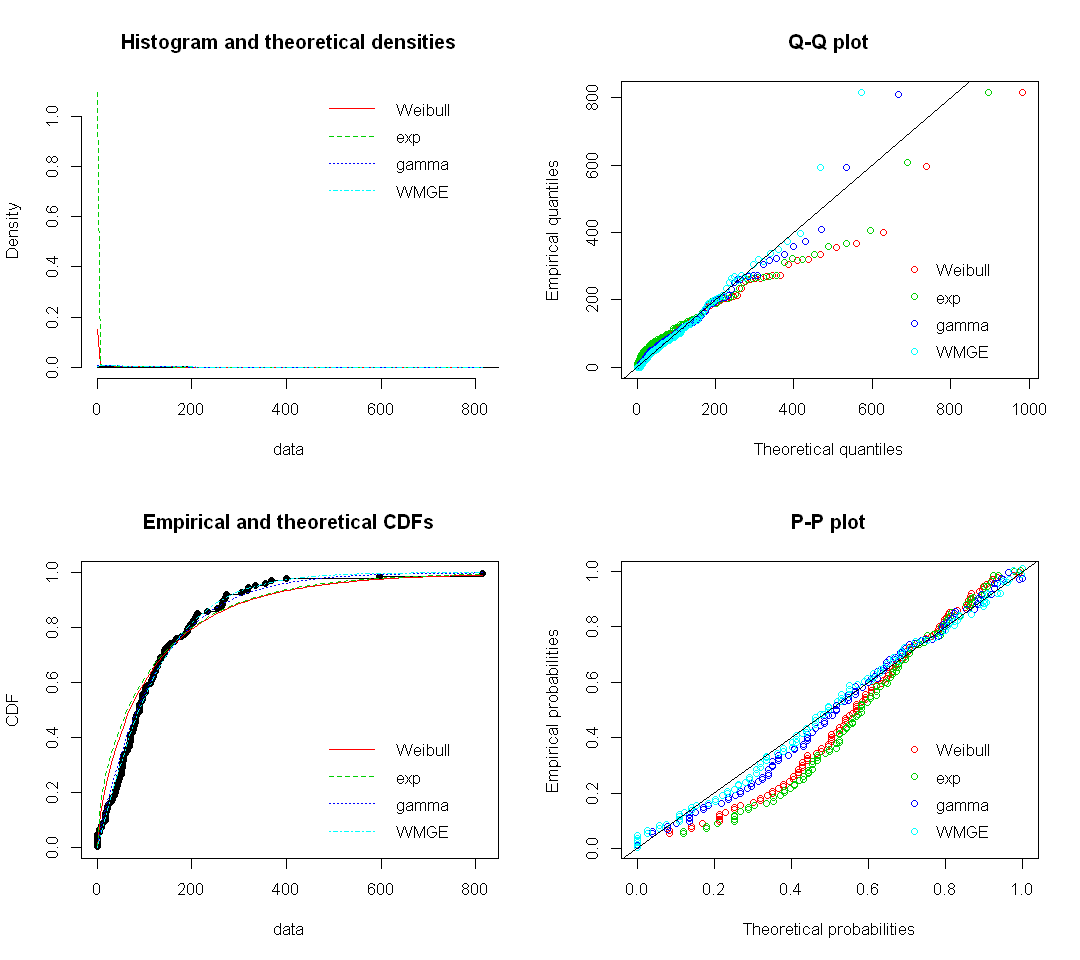

In [73]:
testDist = na.omit(max_PRCP[,3])

    for(j in 1:length(testDist)){
        if(testDist[j] < .1){
        testDist[j]=.0001
        }
    }

fw = fitdist(as.vector(testDist), "weibull", method="mle")
fg = fitdist(as.vector(testDist), "exp", method="mle")
fln = fitdist(as.vector(testDist), "gamma", method="mle")
norm = fitdist(as.vector(testDist), "weibull", method="mge",gof="ADR")

par(mfrow = c(2, 2))
plot.legend <- c("Weibull", "exp", "gamma","WMGE")
denscomp(list(fw, fln, fg,norm), legendtext = plot.legend)
qqcomp(list(fw, fln, fg,norm), legendtext = plot.legend)
cdfcomp(list(fw, fln, fg,norm), legendtext = plot.legend)
ppcomp(list(fw, fln, fg,norm), legendtext = plot.legend)

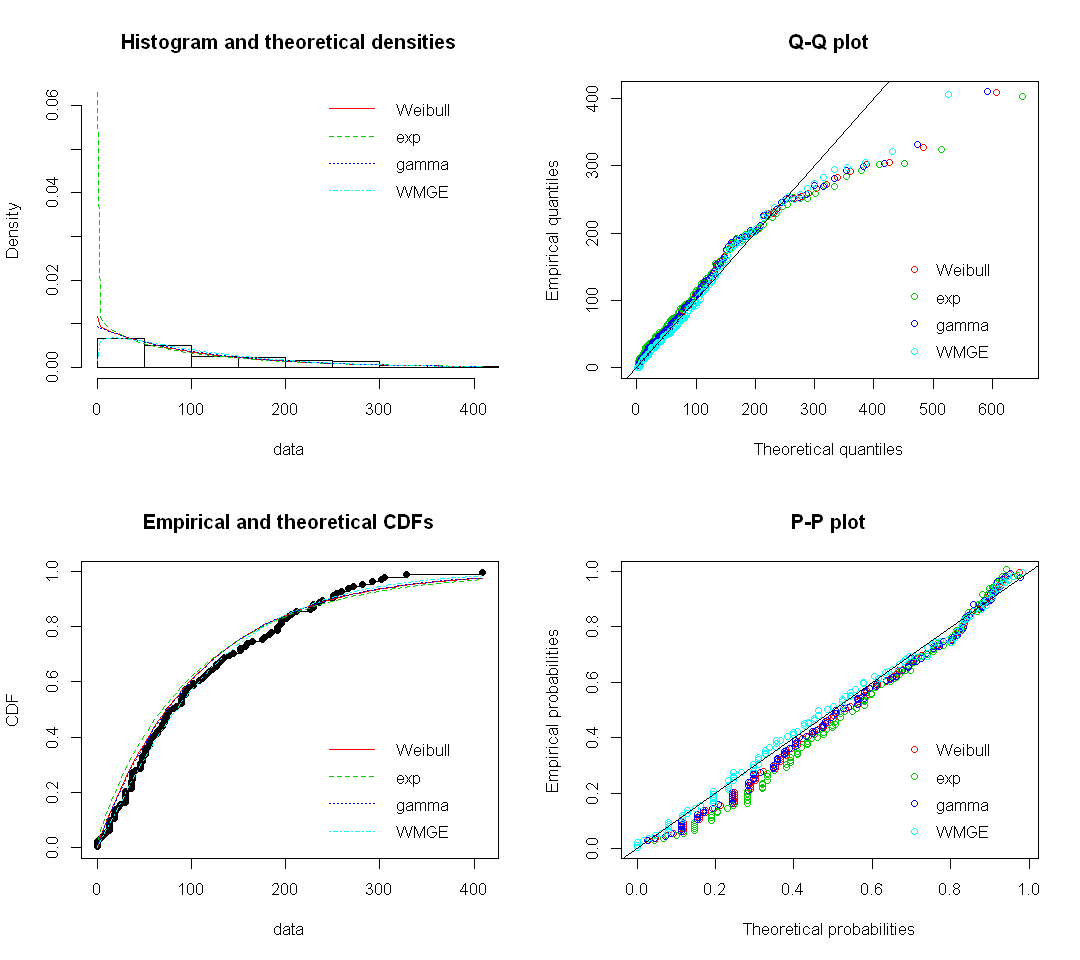

In [74]:
testDist = na.omit(max_PRCP[,45])

    for(j in 1:length(testDist)){
        if(testDist[j] < .1){
        testDist[j]=.0001
        }
    }

fw = fitdist(as.vector(testDist), "weibull", method="mle")
fg = fitdist(as.vector(testDist), "exp", method="mle")
fln = fitdist(as.vector(testDist), "gamma", method="mle")
norm = fitdist(as.vector(testDist), "weibull", method="mge",gof="ADR")

par(mfrow = c(2, 2))
plot.legend <- c("Weibull", "exp", "gamma","WMGE")
denscomp(list(fw, fln, fg,norm), legendtext = plot.legend)
qqcomp(list(fw, fln, fg,norm), legendtext = plot.legend)
cdfcomp(list(fw, fln, fg,norm), legendtext = plot.legend)
ppcomp(list(fw, fln, fg,norm), legendtext = plot.legend)

YET AGAIN, but this time with gamma MGE as well.

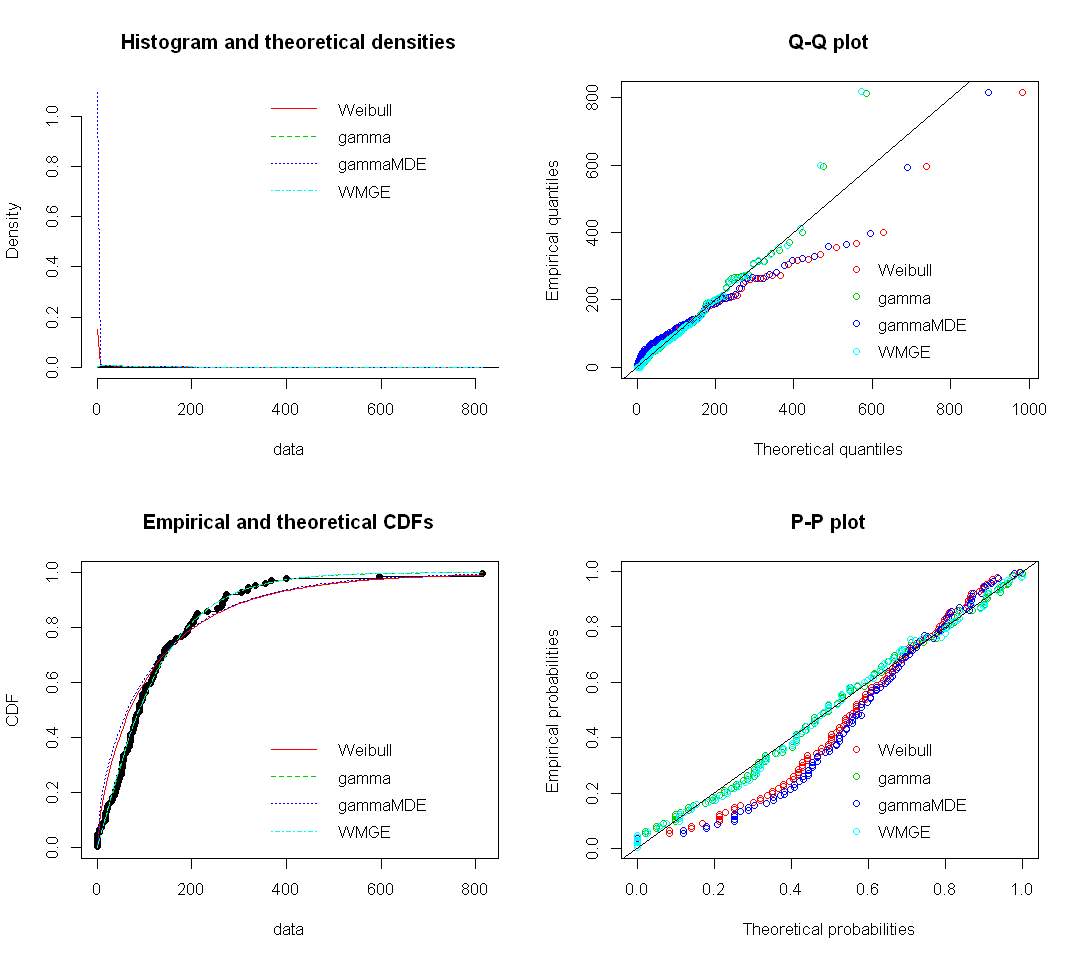

In [75]:
testDist = na.omit(max_PRCP[,3])

    for(j in 1:length(testDist)){
        if(testDist[j] < .1){
        testDist[j]=.0001
        }
    }

fw = fitdist(as.vector(testDist), "weibull", method="mle")
fg = fitdist(as.vector(testDist), "gamma", method="mle")
fln = fitdist(as.vector(testDist), "gamma", method="mge", gof="ADR")
norm = fitdist(as.vector(testDist), "weibull", method="mge",gof="ADR")

par(mfrow = c(2, 2))
plot.legend <- c("Weibull", "gamma", "gammaMDE","WMGE")
denscomp(list(fw, fln, fg,norm), legendtext = plot.legend)
qqcomp(list(fw, fln, fg,norm), legendtext = plot.legend)
cdfcomp(list(fw, fln, fg,norm), legendtext = plot.legend)
ppcomp(list(fw, fln, fg,norm), legendtext = plot.legend)

# Probabilities of Interest 

1 inch of rain approx 25.4mm, 2 inch approx 50.8, 3 inch approx 76.2mm.

Parameter estimates for frequentist probability checks are found in mleGamma2 (using maximum goodness of fit with ADR distance for right tailed data).

probability of seeing or exceeding 1 inch of rain in a 24 hour day

In [76]:
1-pgamma(254, mleGamma2[1,1], mleGamma[1,2])

[1] 0.292929

In [77]:
1-pgamma(508, mleGamma2[1,1], mleGamma[1,2])

[1] 0.07520305

In [78]:
1-pgamma(762, mleGamma2[1,1], mleGamma[1,2])

[1] 0.01876533

In [79]:
oneInch = NULL
twoInch = NULL
threeInch = NULL
for(i in 1:nrow(mleGamma2)){
    oneInch = c(oneInch,1-pgamma(254,mleGamma2[i,1],mleGamma2[i,2]))
    twoInch = c(twoInch,1-pgamma(508,mleGamma2[i,1],mleGamma2[i,2]))
    threeInch = c(threeInch,1-pgamma(762,mleGamma2[i,1],mleGamma2[i,2]))
}

In [80]:
length(oneInch)

[1] 113

In [81]:
starter = firstYear+9

In [82]:
oneInchTS = ts(oneInch, start=starter)
twoInchTS = ts(twoInch, start=starter)
threeInchTS = ts(threeInch, start=starter)

In [83]:
options(repr.plot.width=7,repr.plot.height=5) #reduces the plot sizes

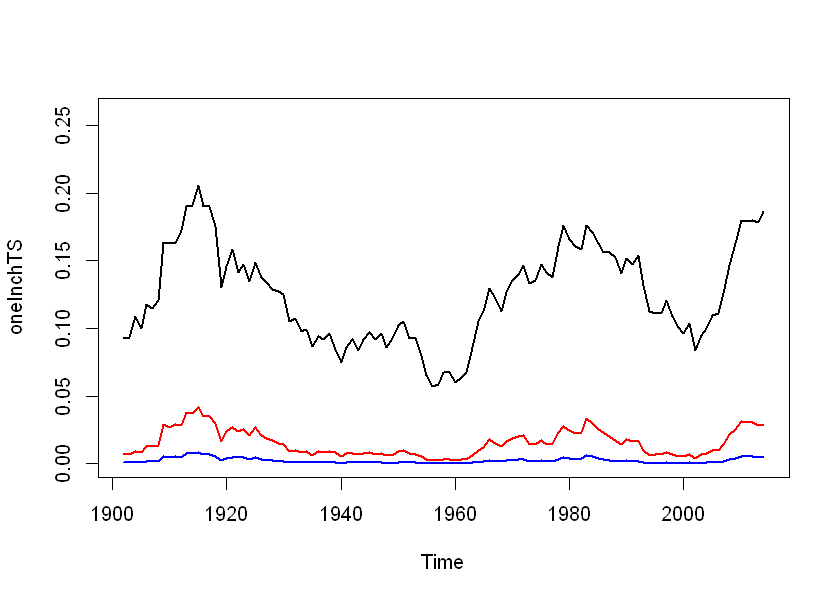

In [84]:
plot(oneInchTS, ylim=c(0,.26), lwd=2)
lines(twoInchTS, col=2, lwd=2)
lines(threeInchTS, col=4, lwd=2)

In [85]:
rollSmall = ts(runmean(oneInchTS,15),start=starter)
rollSmall2 = ts(runmean(oneInchTS,30),start=starter)
rollSmall3 = ts(runmean(oneInchTS,50),start=starter)

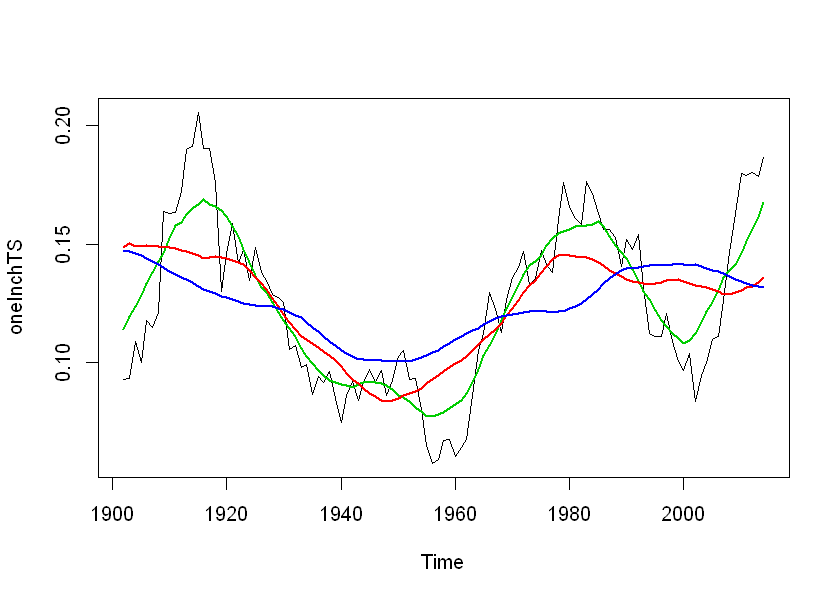

In [86]:
plot(oneInchTS)
lines(rollSmall, col=3,lwd=2)
lines(rollSmall2, col=2,lwd=2)
lines(rollSmall3, col=4,lwd=2)

In [87]:
rollSmall = ts(runmean(twoInchTS,15),start=starter)
rollSmall2 = ts(runmean(twoInchTS,30),start=starter)
rollSmall3 = ts(runmean(twoInchTS,50),start=starter)

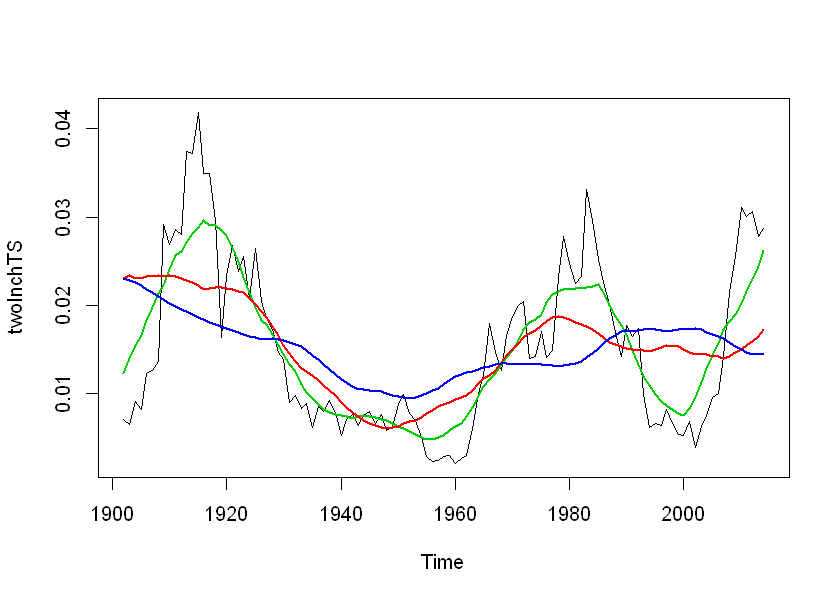

In [88]:
plot(twoInchTS)
lines(rollSmall, col=3,lwd=2)
lines(rollSmall2, col=2,lwd=2)
lines(rollSmall3, col=4,lwd=2)

In [89]:
rollSmall = ts(runmean(threeInchTS,15),start=starter)
rollSmall2 = ts(runmean(threeInchTS,30),start=starter)
rollSmall3 = ts(runmean(threeInchTS,50),start=starter)

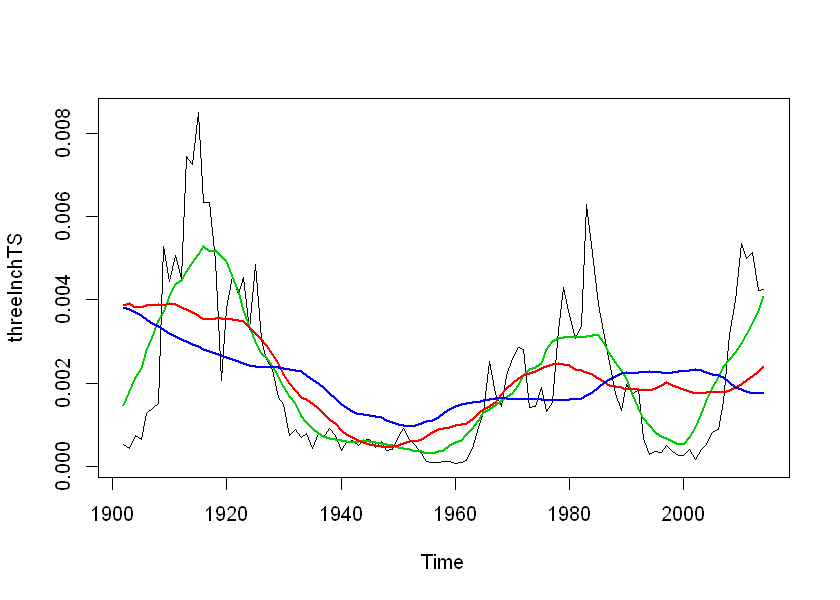

In [90]:
plot(threeInchTS)
lines(rollSmall, col=3,lwd=2)
lines(rollSmall2, col=2,lwd=2)
lines(rollSmall3, col=4,lwd=2)